In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BusinessMonthEnd

# === CONFIG ===
start_date = "2006-01-01"
end_date   = "2021-12-31"
base_value = 100.0
wiki_url   = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# 1) Get constituents
sp500       = pd.read_html(wiki_url)[0]
comm_tcks   = sp500[sp500["GICS Sector"] == "Communication Services"]["Symbol"].tolist()
real_tcks   = sp500[sp500["GICS Sector"] == "Real Estate"]["Symbol"].tolist()
all_tcks    = list(set(comm_tcks + real_tcks))

all_tcks


['T',
 'TTWO',
 'OMC',
 'DIS',
 'CBRE',
 'WY',
 'NWSA',
 'UDR',
 'PARA',
 'REG',
 'META',
 'DOC',
 'HST',
 'MTCH',
 'GOOGL',
 'AMT',
 'CMCSA',
 'ESS',
 'CHTR',
 'VICI',
 'CPT',
 'EQR',
 'PSA',
 'PLD',
 'SPG',
 'BXP',
 'MAA',
 'EQIX',
 'WELL',
 'FRT',
 'IRM',
 'CSGP',
 'GOOG',
 'VTR',
 'NFLX',
 'SBAC',
 'LYV',
 'TMUS',
 'O',
 'ARE',
 'VZ',
 'AVB',
 'EXR',
 'DLR',
 'WBD',
 'EA',
 'FOX',
 'NWS',
 'INVH',
 'FOXA',
 'IPG',
 'TKO',
 'KIM',
 'CCI']

In [34]:

# 2) Download price history
ohlc   = yf.download(all_tcks, start=start_date, end=end_date, auto_adjust=False)
prices = ohlc['Adj Close'].dropna(how='all')

# 3) Fetch float shares (static)
float_shares = {
    t: yf.Ticker(t).info.get("floatShares", np.nan)
    for t in all_tcks
}
float_shares = pd.Series(float_shares).dropna()


[*********************100%***********************]  54 of 54 completed


/var/folders/bf/h6bklz2n1n75m62qstk6lfdr0000gn/T/ipykernel_93206/2802566612.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = period_prices.pct_change().iloc[1:]
/var/folders/bf/h6bklz2n1n75m62qstk6lfdr0000gn/T/ipykernel_93206/2802566612.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = period_prices.pct_change().iloc[1:]
/var/folders/bf/h6bklz2n1n75m62qstk6lfdr0000gn/T/ipykernel_93206/2802566612.py:58: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior 

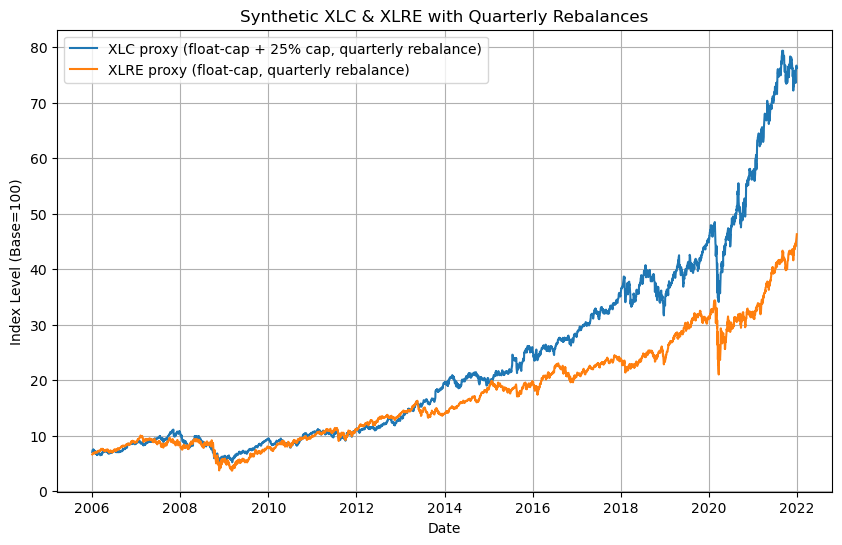

In [35]:

# align tickers that have a float
prices = prices[float_shares.index]

# 4) Determine quarterly rebalance dates (last biz‑day of Feb/May/Aug/Nov)
months = [2, 5, 8, 11]
years  = range(prices.index.year.min(), prices.index.year.max()+1)
rdates = []
for y in years:
    for m in months:
        # first of month
        d = pd.Timestamp(year=y, month=m, day=1) + BusinessMonthEnd(0)
        # if market was open that day, keep; otherwise backfill to prior date in index
        if d in prices.index:
            rdates.append(d)
        else:
            # last price date before d
            prev = prices.index[prices.index < d]
            if len(prev): rdates.append(prev[-1])
rdates = sorted([d for d in rdates if d>=prices.index[0] and d<=prices.index[-1]])

# 5) Build index series period by period
def build_sector_index(tickers, cap_limit=None):
    idx = pd.Series(dtype=float, index=prices.index)
    idx.iloc[0] = base_value

    # split into periods
    period_starts = [prices.index[0]] + rdates
    period_ends   = rdates + [prices.index[-1]]

    for t0, t1 in zip(period_starts, period_ends):
        # get slice of prices for this period
        period_prices = prices.loc[t0:t1, tickers]

        # compute float‐caps at t0
        caps_t0 = float_shares[tickers] * period_prices.iloc[0]
        w = caps_t0 / caps_t0.sum()

        # apply cap if needed (e.g. 25% for XLC)
        if cap_limit is not None:
            # cap & redistribute
            def cap_and_redistribute(w, limit):
                w = w.copy()
                over = w > limit
                while over.any():
                    excess = w[over] - limit
                    w[over] = limit
                    # redistribute excess to those < limit
                    under = ~over
                    total_under = w[under].sum()
                    w[under] += (excess.sum() * (w[under] / total_under))
                    over = w > limit
                return w
            w = cap_and_redistribute(w, cap_limit)

        # now simulate index for t > t0
        prev_idx = idx.loc[t0]
        # daily returns within period
        ret = period_prices.pct_change().iloc[1:]
        # portfolio daily return
        port_ret = ret.mul(w, axis=1).sum(axis=1)
        # build index
        idx.loc[port_ret.index] = prev_idx * (1 + port_ret).cumprod()

    return idx

# 6) Build both series
xlc_proxy = build_sector_index(comm_tcks, cap_limit=0.25)
xlre_proxy= build_sector_index(real_tcks)

# Rescale so final value matches the real XLRE closing price on Dec 30, 2021
real_final_price = 46.304500579833984
synthetic_final_price = xlre_proxy.loc["2021-12-30"]
scaling_factor = real_final_price / synthetic_final_price

# Rescale synthetic XLC to match the real ETF price at 2021-12-30
real_xlc_price = 76.2320785522461  # Actual adjusted close price for XLC on Dec 30, 2021
synthetic_xlc_final = xlc_proxy.loc["2021-12-30"]
scaling_factor_xlc = real_xlc_price / synthetic_xlc_final

# Apply the scaling
xlc_proxy *= scaling_factor_xlc
xlre_proxy *= scaling_factor


# 7) Plot
plt.figure(figsize=(10,6))
plt.plot(xlc_proxy, label="XLC proxy (float‑cap + 25% cap, quarterly rebalance)")
plt.plot(xlre_proxy, label="XLRE proxy (float‑cap, quarterly rebalance)")
plt.title("Synthetic XLC & XLRE with Quarterly Rebalances")
plt.xlabel("Date")
plt.ylabel("Index Level (Base=100)")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import os
import pandas as pd

# Folder path where sector data is stored
folder_path = "./data"
os.makedirs(folder_path, exist_ok=True)

# Function to save with custom second row showing the ticker
def save_with_custom_header(data, ticker_name):
    df = data.to_frame(name="Adj Close")
    
    # Reset index so date is a column
    df_reset = df.reset_index()
    df_reset.columns = ["Date", "Adj Close"]

    # Create a second row with the ticker name under 'Adj Close'
    header = pd.DataFrame([["", ticker_name]], columns=["Date", "Adj Close"])

    # Combine header and data
    final_df = pd.concat([header, df_reset], ignore_index=True)

    # Save to CSV
    final_df.to_csv(os.path.join(folder_path, f"{ticker_name}.csv"), index=False)

# Save both XLC and XLRE with custom format
save_with_custom_header(xlc_proxy, "XLC*")
save_with_custom_header(xlre_proxy, "XLRE*")




In [37]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Load your synthetic index
synthetic_xlc = pd.read_csv('./data/XLC*.csv', parse_dates=['Date'], index_col='Date')

# Grab the only column name
colname = synthetic_xlc.columns[0]

# Load real XLC ETF from Yahoo
real_xlc = yf.download('XLC', start='2018-06-01', end='2021-12-31',auto_adjust=False)

# Align on first common date
common_start = synthetic_xlc.index.intersection(real_xlc.index).min()
print(f'Aligning on: {common_start}')
real_xlc.head()
# Scale the synthetic to match real XLC at that date
scale_factor = real_xlc.loc["2018-06-19"] / synthetic_xlc.loc["2018-06-19", colname]
synthetic_scaled = synthetic_xlc[colname] * scale_factor
synthetic_scaled.name = 'XLC_Synthetic_Scaled'

# Combine both
combined = pd.concat([synthetic_scaled, real_xlc.rename('XLC_Real')], axis=1)

# Plot
plt.figure(figsize=(12, 6))
combined.plot(ax=plt.gca())
plt.title("XLC: Synthetic vs Real (Aligned on Launch Date)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

Aligning on: 2018-06-19 00:00:00


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''